#### 构建一个可迭代的类来模拟一个村庄中，农民与工匠间的贸易：

基本假设：村民们每天需要消耗1份粮食，农民花0.3天并消耗一份工具就能产出一份粮食，但缺乏工具时生产效率会降低，不消耗工具时手刨粮食需要0.8天产出一份(因此将农民生产每份工具的时间近似为0.5天，且农民每天消耗种地时间量的工具)；

农民生产粮食，工具的时间消耗为[0.3, 0.5]；

工匠生产粮食，工具的时间消耗为[0.7, 0.2]。

因此每个村民都具有如下属性：

  生产属性，通过生产单位产品所需的时间衡量；
  
  消耗属性，每日消耗的产品份数；
  
  生产耗时，在生产某种产品上消耗的时间；
  
  贸易量，各商品的卖出，买入份数；
  
  库存状态，每天的(生产-消耗+贸易)量将被加入其中。越缺乏某种产品，越有动力去通过工作或贸易获得之。
  
先考虑不含贸易的类:
每一位村民的初始库存全部为0，他每天消耗在某项产品上的工作时长 = -库存 × 0.1 × 生产效率，

因此村民的产品消耗量为[1,农产品工作时长]

商品定价：每次交易计算 供需比例=(供应-需求)/(供应+需求),下次价格为 价格×EXP(供需比例)

购买行为：得知自己的优势商品后，购买所有值得的不容忍量，并希望出售等价值的商品

In [86]:
import numpy as np
import copy

def normalize_1(matrix):
    """
    归一化矩阵：将矩阵的每一行除以该行的第一列值。
    """
    matrix = np.array(matrix, dtype=float)  # 确保是 NumPy 数组，并转换为浮点数
    return matrix[:, 1:] / matrix[:, 0][:, np.newaxis]  # 每行除以第一列的值

def row_sums(matrix):
    """
    计算矩阵的行和。
    """
    matrix = np.array(matrix, dtype=float)
    return np.sum(matrix, axis=1)  # 按行求和

class Block1(object): 
    def __init__(self, csp, p_t, status, worktime, tps):
        """
        经济模拟系统中的区块（Block1）类。
        
        参数：
        - n: 区块中职业种类数
        - csp: 消费矩阵（职业数量 × 商品种类），表示各职业人口的商品消耗量
        - p_t: 生产时间矩阵（职业数量 × 商品种类），表示生产一单位商品所需时间
        - sts: 状态张量（时间 × 职业数量 × 商品种类），表示库存状态
        - wts: 工作时间张量（时间 × 职业数量 × 商品种类），表示每日生产所花费的时间
        - tps: 商品基准价格列表
        """
        
        # 确保所有矩阵数据都是 NumPy 数组
        self.consumption = np.array(csp, dtype=float)  # 商品消耗量
        self.product_time = np.array(p_t, dtype=float)  # 生产单位商品所需时间
        
        # 计算可承受的最高买入价格/最低卖出价
        self.aff_price = normalize_1(self.product_time)  
        
        # 状态和工作时间存储为张量（时间序列）
        self.status = np.array(status, dtype=float)  # 库存状态序列
        self.worktime = np.array(worktime, dtype=float)  # 工作时间序列
        self.tradeprices = np.array(tps, dtype=float) # 商品的市场价格
        self.category = len(tps) # 商品种类的数目
        self.N = len(status) # 职业数
    
    def evolution(self, consumption):
        """
        经济演化过程。
        
        """

        # 计算各职业的体感价格(生产某商品时赚取单位价值所需的时间，并倾向于生产效率最高的产品)
        self.feel_price = self.product_time / self.tradeprices
        # 找到对某职业相对最优势的商品序号
        self.choice = np.array(np.argmin(couple.feel_price, axis=1),dtype=int)
        
        #计算各职业每日拟购买的各商品量（去除优势商品后，购买所有其他商品,库存越少想买越多）
        self.needs = -self.status * 0.2
        self.needs[range(self.N), self.choice] = 0
        #对所有职业求和得到各商品量的需求量
        self.need = np.sum(self.needs, axis=0)
        #计算在市场上拟支出的金额（商品消耗量 × 商品价值）
        self.expend = self.needs * self.tradeprices
        #计算在市场上拟出售的(优势)商品数量
        self.sell = np.sum(self.expend, axis=1) / self.tradeprices[self.choice]
        #计算各商品的供应量（将出售量放入商品种类对应的位置）
        self.provide = np.zeros(self.category)
        np.add.at(self.provide, self.choice, self.sell)
        
        # 供需比例
        self.ndp = self.provide / self.need
        self.ndp[self.ndp > 1] = 1
        # 各职业被满足的需求量
        self.filled = self.needs * self.ndp
        # 需供比例
        self.pdn = self.need / self.provide
        self.pdn[self.pdn > 1] = 1
        # 各职业卖出的商品量
        self.sold = self.provide * self.pdn
        
        # 计算每日工作时间（基于商品缺乏程度 * 耐受度（即1/5的工作时间，以保证库存在-5时单人独自能达到平衡））
        self.worktime = (-self.status * 0.2 - 0) * self.product_time
#         self.filled[self.filled > 0] = self.filled[self.filled > 0] + 1
        self.test = (-self.status * 0.2 - self.filled) * self.product_time
        self.test[self.test < 0] = 0
        
        # 计算各职业每日生产量 = 生产工作时间 / 生产单位商品所需时间
        production = self.worktime / self.product_time
        
        # 计算每日非必须品消耗（工具消耗即工作时间）
        self.consumption[:,1] = production[:,0]
        
        # 计算总劳动负担（每个职业的工作时间总和）
        loading = row_sums(self.worktime)
        
        # 计算新库存状态：旧库存 + 生产 - 消耗 + 贸易变化
        self.status = self.status + production - self.consumption
        self.statustest = self.status + production - self.consumption + self.filled - self.sold
        
        # 加权供需比例作为调整价格的基数
        self.change = (self.provide - self.need) / (self.need + self.provide)

粮食价格较低，工具价格适中，衣服价格较高，
造成粮食求过于供，工具刚好平衡，衣服供过于求

In [93]:
# 创建实例
Status = [];
Worktimes = [];
couple = Block1( 
               np.ones([3,3]), 
               [[0.4, 0.4, 0.2],[0.2, 0.3, 0.3], [0.4, 0.1, 0.4]], 
               np.ones([3,3]), 
               np.zeros([3,3]), 
               [1,1.2,1.4])
for i in range(60):
    couple.evolution([[1, 0], [1, 0]])
    Status.append(couple.status)
    Worktimes.append(couple.worktime),

In [94]:
# 参数检查
for attr, value in vars(couple).items():
    print(f"{attr} = {value}")

consumption = [[1.        0.9999977 1.       ]
 [1.        0.9999977 1.       ]
 [1.        0.9999977 1.       ]]
product_time = [[0.4 0.4 0.2]
 [0.2 0.3 0.3]
 [0.4 0.1 0.4]]
aff_price = [[1.   0.5 ]
 [1.5  1.5 ]
 [0.25 1.  ]]
status = [[-4.99999081 -4.99985288 -4.99999081]
 [-4.99999081 -4.99985288 -4.99999081]
 [-4.99999081 -4.99985288 -4.99999081]]
worktime = [[0.39999908 0.39998552 0.19999954]
 [0.19999954 0.29998914 0.29999931]
 [0.39999908 0.09999638 0.39999908]]
tradeprices = [1.  1.2 1.4]
category = 3
N = 3
feel_price = [[0.4        0.33333333 0.14285714]
 [0.2        0.25       0.21428571]
 [0.4        0.08333333 0.28571429]]
choice = [2 0 1]
needs = [[0.9999977  0.99996379 0.        ]
 [0.         0.99996379 0.9999977 ]
 [0.9999977  0.         0.9999977 ]]
need = [1.9999954  1.99992759 1.9999954 ]
expend = [[0.9999977  1.19995655 0.        ]
 [0.         1.19995655 1.39999678]
 [0.9999977  0.         1.39999678]]
sell = [1.5713959  2.59995334 1.9999954 ]
provide = [2.59995334

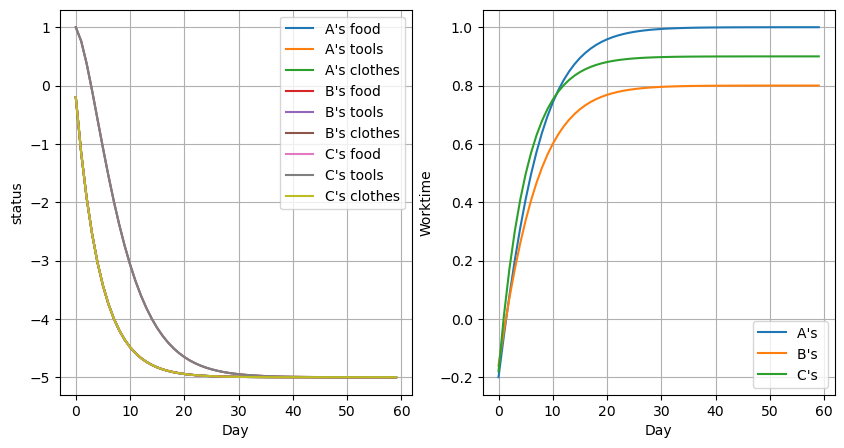

In [95]:
import matplotlib.pyplot as plt
names = ["A's ", "B's ", "C's "];
goods = ["food", "tools", "clothes", "gold"];
final = Status
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

x=range(0,len(final))
def fun_fianl(x,i,j):
    return [final[y][i][j] for y in x]
for i in range(len(final[0])):
    for j in range(len(final[0][1])):
        ax[0].plot(x, fun_fianl(x,i,j),label = names[i] + goods[j])
ax[0].set_xlabel('Day')
ax[0].set_ylabel('status')
ax[0].legend(loc='best')
ax[0].grid()
y = np.array(list(map(row_sums,Worktimes))).T
for i in range(len(y)):
    ax[1].plot(x,y[i], label = names[i])
ax[1].set_xlabel('Day')
ax[1].set_ylabel('Worktime')
ax[1].legend(loc='best')
ax[1].grid()